In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

from lib_pic1d.boundary import * 
from lib_pic1d.maxwell import *
from lib_pic1d.others import * 
from lib_pic1d.particles_booster import *

## 全過程

初期設定

In [121]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/100
t_r = 1/100
m_electron = 1 * m_unit
m_ion = m_electron / r_m
r_q = 1.0
T_e = 1/2 * m_electron * (0.01*c)**2
T_i = T_e / t_r
n_e = 100 #ここは手動で調整すること
B0 = np.sqrt(n_e) / 10.0
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
n_i = int(n_e * np.abs(q_electron) / q_ion)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
V_A = c * np.sqrt(B0**2 / (n_e*m_electron + n_i*m_ion))
C_S = np.sqrt(r_m * T_e)
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)

dx = debye_length
n_x = 512
x_max = n_x * dx
x_coordinate = np.arange(0.0, x_max, dx)
dt = 1.0
step = 50000
t_max = step * dt
v_thermal_ion = np.sqrt(T_i / m_ion)
v_thermal_electron = np.sqrt(T_e / m_electron)
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([-10.0*v_thermal_ion, 0.0, 0.0])
v_beam = np.array([10.0*v_thermal_ion, 0.0, 0.0])
if c * dt > dx:
    print(f"You had better change some parameters! \nCFL condition is not satisfied \n c * dt = {c * dt} > dx = {dx} \n")
else:
    print(f'c * dt = {c * dt} < dx = {dx} \n')

if omega_pe * dt > 0.2:
    print(f"You had better change some parameters! \n$\omega$_pe * dt = {omega_pe * dt} > 0.1 \n")
if round(dx, 5) != 1.0:
    print(f"You had better change some parameters! \ndebye length = {debye_length} should be equal to grid size = {dx} \n")


E = np.zeros([3, len(x_coordinate)])
B = np.zeros([3, len(x_coordinate)])
current = np.zeros([3, len(x_coordinate)])

n_plus = int(n_x * n_i)
n_minus = int(n_x * n_e / 2)
n_beam = int(n_x * n_e / 2)
np.random.RandomState(1)
x_start_plus = np.random.rand(n_plus) * x_max
x_start_minus = np.random.rand(n_minus) * x_max
x_start_beam = np.random.rand(n_beam) * x_max
print(f"total number of particle is {n_plus + n_minus + n_beam}")

x = np.zeros([3, n_plus + n_minus + n_beam])
v = np.zeros([3, n_plus + n_minus + n_beam])
x[0, :] = np.concatenate([x_start_plus, x_start_minus, x_start_beam])
v[0, :n_plus] = np.array(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_plus))
v[0, n_plus:n_plus + n_minus] = np.array(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_minus))
v[0, n_plus + n_minus:] = np.array(stats.norm.rvs(v_beam[0], v_thermal_electron, size=n_beam))
v[1, :n_plus] = np.array(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_plus))
v[1, n_plus:n_plus + n_minus] = np.array(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_minus))
v[1, n_plus + n_minus:] = np.array(stats.norm.rvs(v_beam[1], v_thermal_electron, size=n_beam))
v[2, :n_plus] = np.array(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_plus))
v[2, n_plus:n_plus + n_minus] = np.array(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_minus))
v[2, n_plus + n_minus:] = np.array(stats.norm.rvs(v_beam[2], v_thermal_electron, size=n_beam))

q_list = np.zeros(n_plus + n_minus + n_beam)
q_list[:n_plus] = q_ion
q_list[n_plus:] = q_electron
m_list = np.zeros(n_plus + n_minus + n_beam)
m_list[:n_plus] = m_ion
m_list[n_plus:] = m_electron

c * dt = 0.5 < dx = 1.0 

total number of particle is 102400


In [16]:
#STEP1
rho = get_rho(q_list, x, n_x, dx)
E = solve_poisson_not_periodic(rho, n_x, epsilon0, dx, E)  

for k in range(step+1):
    if k % 100 == 0:
        print(f'{k*dt} done...')

    #STEP2
    B = time_evolution_B(E, dx, dt/2, B)   
    #STEP3
    v = time_evolution_v(c, E, B, x, q_list, m_list, n_x, dx, dt, v)
    #STEP4
    x = time_evolution_x(c, dt/2, v, x)
    x = periodic_condition_x(x_max, x)
    #STEP5
    current = get_current_density(c, q_list, v, x, n_x, dx, dt)
    #STEP6
    B = time_evolution_B(E, dx, dt/2, B) 
    #STEP7
    E = time_evolution_E(B, current, c, epsilon0, dx, dt, E)
    #STEP8
    x = time_evolution_x(c, dt/2, v, x)
    x = periodic_condition_x(x_max, x)

    if k % 100 == 0:
        k1 = k // 100
        KE = np.sum(1/2 * m_list * np.linalg.norm(v, axis=0)**2)
        np.save(f'two_stream_electron/results_1pic_two_stream_electron_xv_{k1}.npy', np.concatenate([x, v]))
        np.save(f'two_stream_electron/results_1pic_two_stream_electron_E_{k1}.npy', E)
        np.save(f'two_stream_electron/results_1pic_two_stream_electron_B_{k1}.npy', B)
        np.save(f'two_stream_electron/results_1pic_two_stream_electron_current_{k1}.npy', current)
        np.save(f'two_stream_electron/results_1pic_two_stream_electron_KE_{k1}.npy', KE)

0.0 done...
100.0 done...
200.0 done...
300.0 done...
400.0 done...
500.0 done...
600.0 done...
700.0 done...
800.0 done...
900.0 done...
1000.0 done...
1100.0 done...
1200.0 done...
1300.0 done...
1400.0 done...
1500.0 done...
1600.0 done...
1700.0 done...
1800.0 done...
1900.0 done...
2000.0 done...
2100.0 done...
2200.0 done...
2300.0 done...
2400.0 done...
2500.0 done...
2600.0 done...
2700.0 done...
2800.0 done...
2900.0 done...
3000.0 done...
3100.0 done...
3200.0 done...
3300.0 done...
3400.0 done...
3500.0 done...
3600.0 done...
3700.0 done...
3800.0 done...
3900.0 done...
4000.0 done...
4100.0 done...
4200.0 done...
4300.0 done...
4400.0 done...
4500.0 done...
4600.0 done...
4700.0 done...
4800.0 done...
4900.0 done...
5000.0 done...


#######################################################

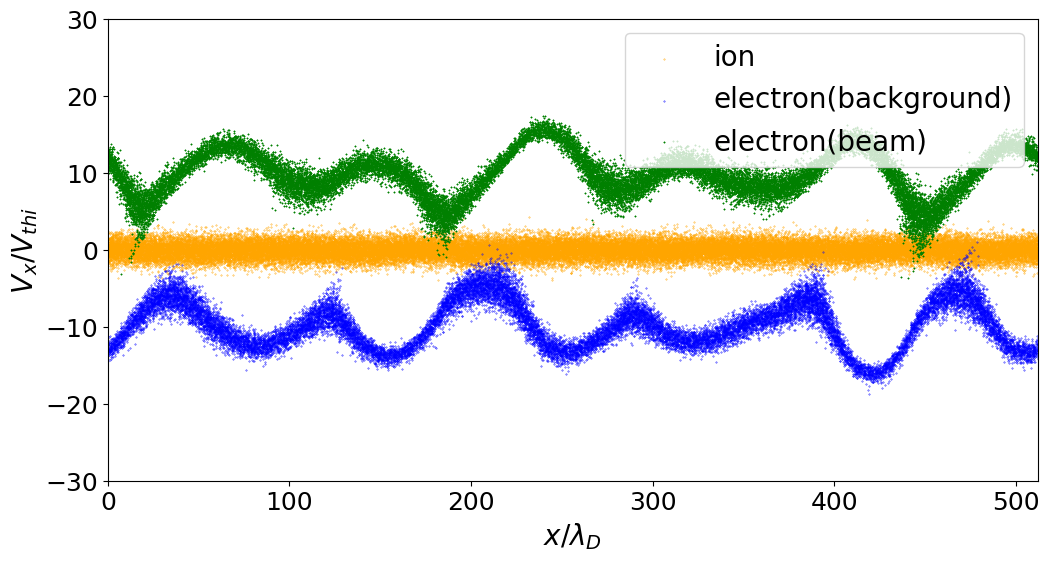

In [28]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

results_total = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_xv_{25}.npy")
ax.scatter(results_total[0, :n_plus], results_total[3, :n_plus]/v_thermal_ion, s=0.1, c='orange', label='ion')
ax.scatter(results_total[0, n_plus:n_plus+n_minus], results_total[3, n_plus:n_plus+n_minus]/v_thermal_electron, s=0.1, c='blue', label='electron(background)')
ax.scatter(results_total[0, n_plus+n_minus:], results_total[3, n_plus+n_minus:]/v_thermal_electron, s=0.1, c='green', marker='*', label='electron(beam)')
ax.set_xlim(0, x_max)
ax.set_ylim(-30, 30)
ax.set_xlabel('$x / \lambda_D$', fontsize=20)
ax.set_ylabel('$V_x / V_{thi}$', fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc='upper right', fontsize=20)
    

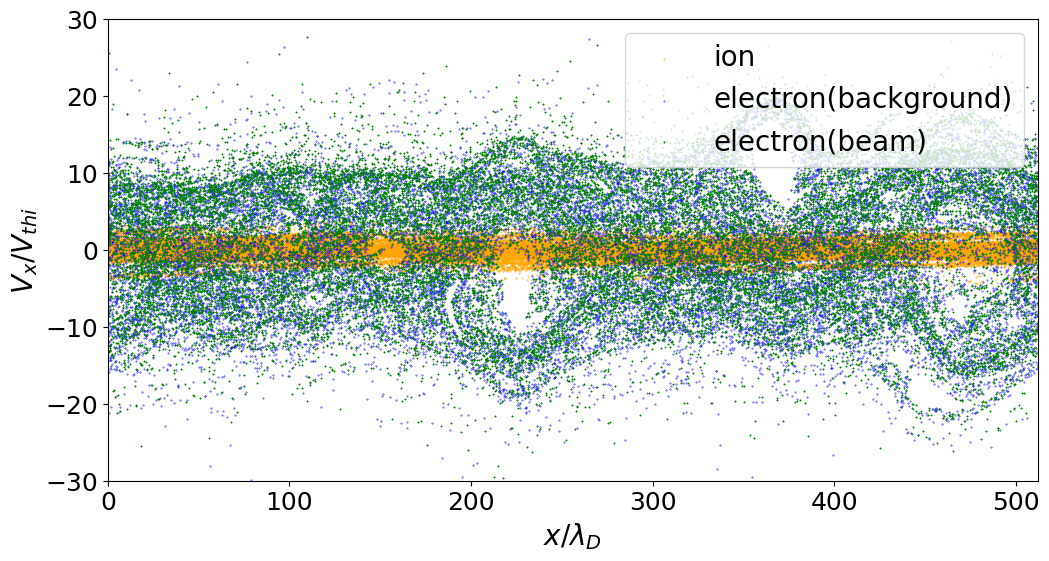

In [3]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

interval = 1
number_of_results = 501
for i in range(number_of_results):
    results_total = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_xv_{i}.npy")
    ax.clear()
    ax.scatter(results_total[0, :n_plus], results_total[3, :n_plus]/v_thermal_ion, s=0.1, c='orange', label='ion')
    ax.scatter(results_total[0, n_plus:n_plus+n_minus], results_total[3, n_plus:n_plus+n_minus]/v_thermal_electron, s=0.1, c='blue', label='electron(background)')
    ax.scatter(results_total[0, n_plus+n_minus:], results_total[3, n_plus+n_minus:]/v_thermal_electron, s=0.1, c='green', marker='*', label='electron(beam)')
    ax.set_xlim(0, x_max)
    ax.set_ylim(-30, 30)
    ax.set_xlabel('$x / \lambda_D$', fontsize=20)
    ax.set_ylabel('$V_x / V_{thi}$', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.legend(loc='upper right', fontsize=20)
    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=f'two_stream_electron.mp4', fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

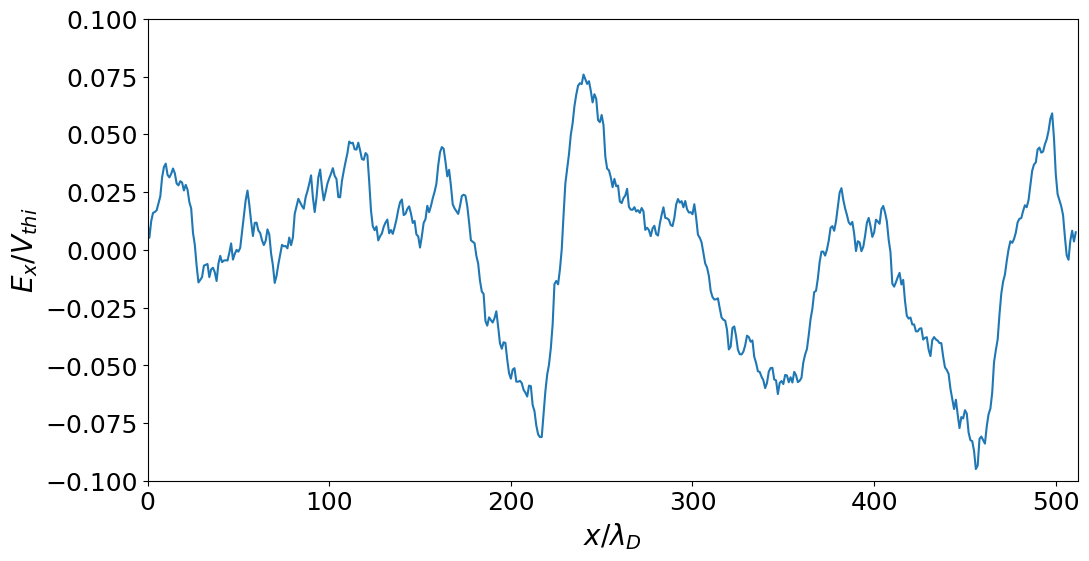

In [4]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

interval = 1
number_of_results = 501
for i in range(number_of_results):
    results_total_E = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_E_{i}.npy")
    ax.clear()
    ax.plot(x_coordinate, results_total_E[0, :])
    ax.set_xlim(0, x_max)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('$x / \lambda_D$', fontsize=20)
    ax.set_ylabel('$E_x / V_{thi}$', fontsize=20)
    ax.tick_params(labelsize=18)
    fig.savefig(f'./pictures_E/{i}.png', dpi=200)


img = cv2.imread(f'./pictures_E/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=f'two_stream_electron_E_x.mp4', fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./pictures_E/{i}.png')
    video.write(img)
video.release()

0.9998292223735973


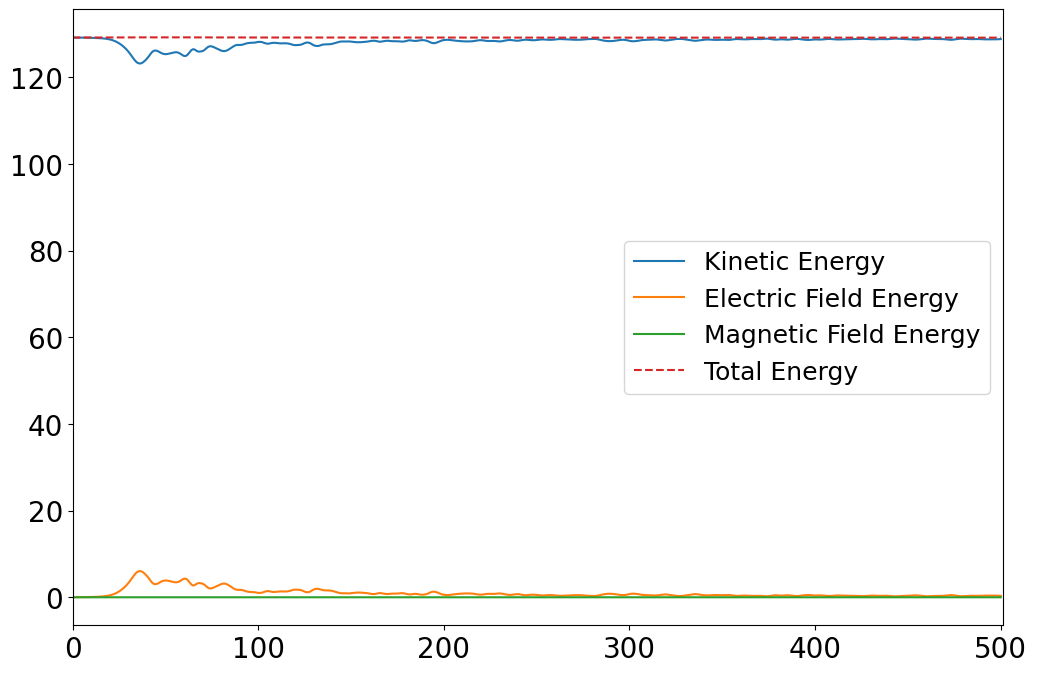

In [5]:
step = 501
kinetic_energy = np.zeros(step)
electric_field_energy = np.zeros(step)
magnetic_field_energy = np.zeros(step)
t = np.arange(0.0, step)

for i in range(step):
    results_total_KE = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_KE_{i}.npy")
    results_total_E = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_E_{i}.npy")
    results_total_B = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_B_{i}.npy")
    kinetic_energy[i] = results_total_KE
    electric_field_energy[i] = np.sum(1/2 * epsilon0 * np.linalg.norm(results_total_E[:, :], axis=0)**2)
    magnetic_field_energy[i] = np.sum(1/2 / mu_0 * np.linalg.norm(results_total_B[:, :], axis=0)**2)

total_energy = kinetic_energy + electric_field_energy + magnetic_field_energy
print(total_energy[-1] / total_energy[0])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(t, kinetic_energy, label='Kinetic Energy')
ax.plot(t, electric_field_energy, label='Electric Field Energy')
ax.plot(t, magnetic_field_energy, label='Magnetic Field Energy')
ax.plot(t, total_energy, label='Total Energy', ls='--')
ax.legend(loc='best', fontsize=18)
ax.set_xlim(0.0, step)
ax.tick_params(labelsize=20)
fig.savefig("two_stream_electron_energy.png")
plt.show()

### 分散関係などを調べる

【理論】
電場をフーリエ変換した際、ピーク周辺の波数$k_{max}$と成長率$\gamma_{max}$の関係は、
\begin{equation*}
    \gamma_{max} \simeq \dfrac{\omega_{pe}}{4}
\end{equation*}

\begin{equation*}
    k_{max} \simeq \dfrac{\sqrt{3}}{2} \dfrac{\omega_{pe}}{v_d}
\end{equation*}
となる（らしい）。$v_d$は熱速度×(ビーム電子速度/背景電子速度)。

$\ln |E_k|^2$と$\omega_{pe}t$のグラフを作るとき、序盤の傾きが$\frac{1}{2}$になってればOK。

http://www.astro.phys.s.chiba-u.ac.jp/pcans/em1d_ebeam.html#id4

(0.0, 10.0)

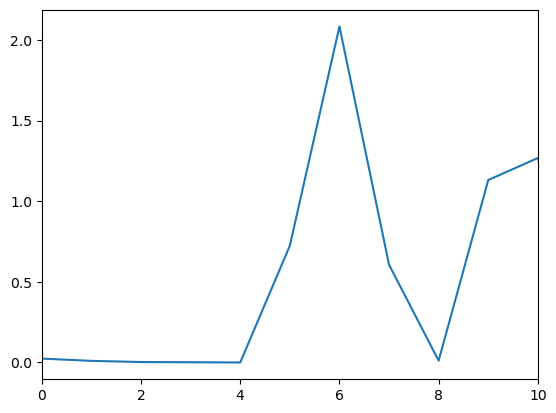

In [43]:
results_E = np.load('two_stream_electron/results_1pic_two_stream_electron_E_10.npy')

E_FFT = np.fft.fft(results_E[0, :] * np.hanning(n_x))
peak_index = np.argsort(E_FFT[:n_x//2].real**2)[-2:]

plt.plot(E_FFT.real**2)
plt.xlim(0, 10)

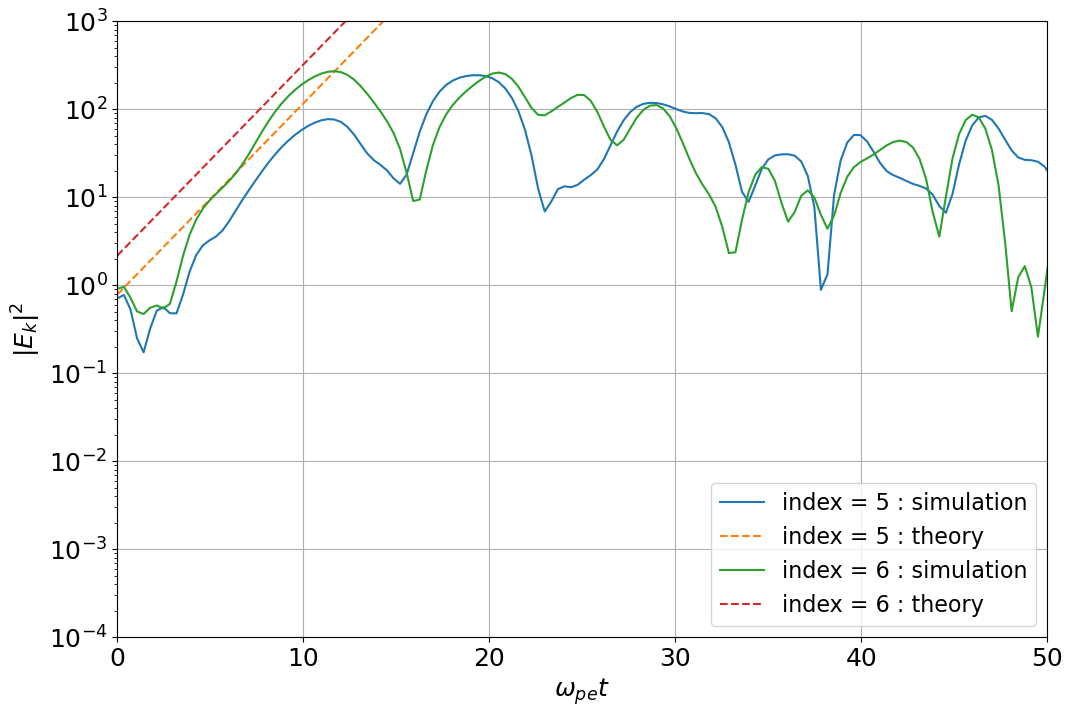

In [44]:
results_E = np.load('two_stream_electron/results_1pic_two_stream_electron_E_30.npy')

E_FFT = np.fft.fft(results_E[0, :] * np.hanning(n_x))
peak_index = np.argsort(E_FFT[:n_x//2].real**2)[-2:]

step = 50000
number_of_results = 501
FFT_peak = np.zeros([len(peak_index), number_of_results], dtype=np.complex64)
for i in range(number_of_results):
    results_E = np.load(f'two_stream_electron/results_1pic_two_stream_electron_E_{i}.npy')
    E_FFT = np.fft.fft(results_E[0, :] * np.hanning(n_x))
    FFT_peak[:, i] = E_FFT[peak_index]


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for i in range(len(peak_index)):
    t = np.arange(0.0, step+1, 100)
    ax.plot(omega_pe * t, np.abs(FFT_peak[i]) ** 2, label=f'index = {peak_index[i]} : simulation')
    ax.plot(omega_pe * t, np.abs(FFT_peak[i])[10] ** 2 * np.exp(1/2 * (t*omega_pe)), ls='--', label=f'index = {peak_index[i]} : theory')
    
ax.grid()
ax.set_yscale('log')
ax.set_xlabel('$\omega_{pe}t$', fontsize=18)
ax.set_ylabel('$|E_k|^2$', fontsize=18)
ax.set_xlim(0, 50)
ax.set_ylim(1e-4, 1e3)
ax.tick_params(labelsize=18)
ax.legend(loc='lower right', fontsize=16)
fig.savefig('two_stream_electron_E_x_dispersion.png')
plt.show()

In [38]:
np.sqrt(3)/2*omega_pe/(20*v_thermal_electron), 1/n_x*5

(0.043301270189221926, 0.009765625)